# EDA and Cleaning

In the last notebook I collected the data in this I will explore the data and clean it.

---

In [300]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re

## Functions

In [301]:
def count_most_common_words(df, column_to_vectirize, n_most_common, ngram_range=(1,1)):
    '''
    Takes:
    Data Frame
    Column that needs to be vectorized
    Number of most common words to return
    Ngram_range Tuple "The lower and upper boundary of the range of n-values for different word n-grams" default (1,1)
    
    Outputs:
    Data Frame with N most common words
    
    '''
    cvec = CountVectorizer(ngram_range=ngram_range, stop_words = 'english')
    cvec.fit(df[column_to_vectirize])
    vectorized_column = cvec.transform(df[column_to_vectirize])
    vectorized_df = pd.DataFrame(vectorized_column.todense(), columns = cvec.get_feature_names_out())
    return vectorized_df.sum().sort_values(ascending = False).head(n_most_common)

In [302]:
def remove_words(df, column, list_of_words):
    '''   
    Function to remove words from the column in the Data Frame
    Input:
    Data Frame
    Column from which to remove words
    List of words to remove
    
    Outputs Data Frame with words removed from the column
    '''
    for word in list_of_words:
        df[column] = df[column].str.replace(word, '')
    return df

In [303]:
def delete_links_chunks(df, column):
    '''
    Function to remove links and other non-word chunks from the column in the Data Frame
    Input:
    Data Frame
    Column from which to remove words
    
    Outputs Data Frame column with links and chunks removed from the column
    '''
    df[column] = df[column].apply(lambda x: re.sub(r'.{0,7}._r\d\.fq.{0,5}', '', x)) 
    df[column] = df[column].apply(lambda x: re.sub(r'(\\n)*&amp.*', '', x)) 
    df[column] = df[column].apply(lambda x: re.sub(r'(https.*\s|https.*\d)', '', x))
    return  df[column]   

---

In [304]:
# Get the data
reddit = pd.read_csv('../data/reddit.csv')

In [305]:
reddit.head()

,subreddit,selftext,title,created_utc
0,bioinformatics,This question has been dealt with before in th...,Differences between genome builds,1673302734
1,bioinformatics,"&amp;#x200B;\n\nCurious, anyone in need of a c...",Anyone need a solid Rust developer familiar wi...,1673291931
2,bioinformatics,NaN,We're wasting money by only supporting gzip fo...,1673287206
3,bioinformatics,I want to quickly check whether a particular g...,Any publicly available mapped human WGS datase...,1673284236
4,bioinformatics,I am currently working on the Gut microbiome a...,Pipeline for Gene Sequencing,1673280166


In [306]:
# Selftext is a bit obscure name, I want to change it to be more explicit 
reddit.rename(columns = {'selftext': 'post_body_text'}, inplace = True)
reddit.head()

,subreddit,post_body_text,title,created_utc
0,bioinformatics,This question has been dealt with before in th...,Differences between genome builds,1673302734
1,bioinformatics,"&amp;#x200B;\n\nCurious, anyone in need of a c...",Anyone need a solid Rust developer familiar wi...,1673291931
2,bioinformatics,NaN,We're wasting money by only supporting gzip fo...,1673287206
3,bioinformatics,I want to quickly check whether a particular g...,Any publicly available mapped human WGS datase...,1673284236
4,bioinformatics,I am currently working on the Gut microbiome a...,Pipeline for Gene Sequencing,1673280166


In [307]:
# Check for missing data
reddit.isnull().sum()

subreddit           0
post_body_text    399
title               0
created_utc         0
dtype: int64

In my subreddits the text of the post is missing in some cases, I will model on the title first and then add text and see if F1 score will improve. The created_utc was used for collecting the data and I do not need it for modeling

In [308]:
reddit.drop(columns = 'created_utc', inplace = True)

In [309]:
# Find the base line
reddit['subreddit'].value_counts(normalize=True)

datascience       0.672108
bioinformatics    0.327892
Name: subreddit, dtype: float64

My baseline is 67%

In [310]:
# Change text to lowercase
reddit['title'] = reddit['title'].str.lower()
reddit['post_body_text'] = reddit['post_body_text'].str.lower()

In [311]:
# Change subreddits names to numbers for modeling
reddit['subreddit_num'] = reddit['subreddit'].map({'bioinformatics': 1, 'datascience': 0})
reddit.head()

,subreddit,post_body_text,title,subreddit_num
0,bioinformatics,this question has been dealt with before in th...,differences between genome builds,1
1,bioinformatics,"&amp;#x200b;\n\ncurious, anyone in need of a c...",anyone need a solid rust developer familiar wi...,1
2,bioinformatics,NaN,we're wasting money by only supporting gzip fo...,1
3,bioinformatics,i want to quickly check whether a particular g...,any publicly available mapped human wgs datase...,1
4,bioinformatics,i am currently working on the gut microbiome a...,pipeline for gene sequencing,1


In [312]:
# Check the numbers are correct
reddit['subreddit_num'].value_counts()

0    1400
1     683
Name: subreddit_num, dtype: int64

In [313]:
# Check the difference between title and self_text length for Bioinformatics and Data Science
reddit['title_length'] = reddit['title'].map(lambda x: len(x))
reddit['post_body_text_length'] = reddit['post_body_text'].map(lambda x: len(str(x)))
reddit.groupby('subreddit')[['title_length', 'post_body_text_length']].mean()

,title_length,post_body_text_length
subreddit,,
bioinformatics,58.361640,551.986823
datascience,59.399286,473.395714


The average Title length is about the same for Bioinformatics and Data Science, however, the average length of the body of the post is different, higher for bioinformatics.
I want to check if most of the missing texts are from Data Science.

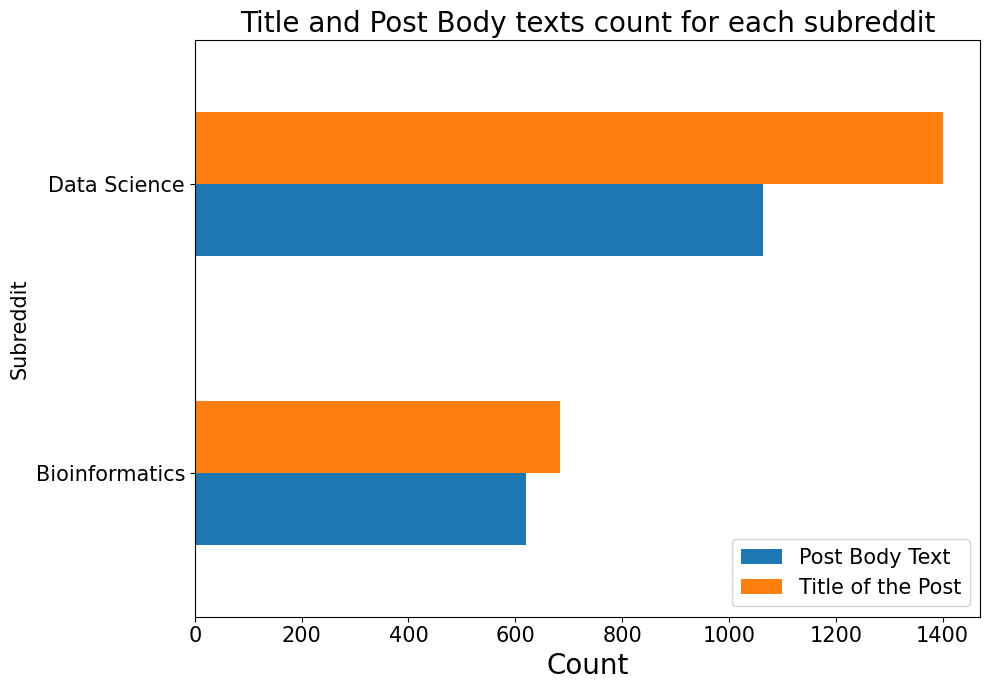

In [314]:
reddit.groupby('subreddit')[['post_body_text', 'title']].count().plot(kind='barh', figsize=(10, 7));
plt.title('Title and Post Body texts count for each subreddit', size = 20)
plt.xticks(size = 15)
plt.xlabel('Count', size = 20)
plt.yticks(np.arange(2), ['Bioinformatics', 'Data Science'], size = 15)
plt.ylabel('Subreddit', size = 15)
plt.legend(fontsize = 15, labels = ['Post Body Text', 'Title of the Post'])
plt.tight_layout()
plt.savefig('../images/title_post_body_counts.jpeg');

As I suspected Data Science has much more missing post-body texts than Bioinformatics, which can influence the average length of the post.

In [315]:
# Check the difference between the title word count for Bioinformatics and Data Science 
reddit['title_word_count'] = reddit['title'].map(lambda x: len(x.split()))
reddit.groupby('subreddit')['title_word_count'].mean()

subreddit
bioinformatics     9.229868
datascience       10.011429
Name: title_word_count, dtype: float64

The difference between the average count of words per title is small.

## Most Common Words

---

### Title Most Common Words

In [316]:
# Most Common Words in Data Science Subreddit
datascience_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'datascience'], 'title', 10)
datascience_title_most_common

data         646
science      331
resume        77
ds            70
learning      66
job           63
best          60
analytics     60
scientist     59
python        54
dtype: int64

In [317]:
# Most Common Words in Bioinformatics Subreddit
bioinformatics_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'bioinformatics'], 'title', 10)
bioinformatics_title_most_common

bioinformatics    110
data               52
help               46
gene               36
analysis           32
seq                25
using              24
phd                23
cell               22
genome             21
dtype: int64

Data and Science are by far the most common words in Data Science Subreddit. I can see that data in it is used not only together with Science, but it is also too prevalent still to use in modeling. In Bioinformatics the most common word by far is bioinformatics. I will need to remove the names of subreddits from the features to train the model to recognize subreddits without this easy clue.

In [318]:
# Drop data, science, ds, and bioinformatics from Reddit data
words_to_delete = ['bioinformatics', 'data', 'science', 'ds']

reddit = remove_words(reddit, 'title', words_to_delete)

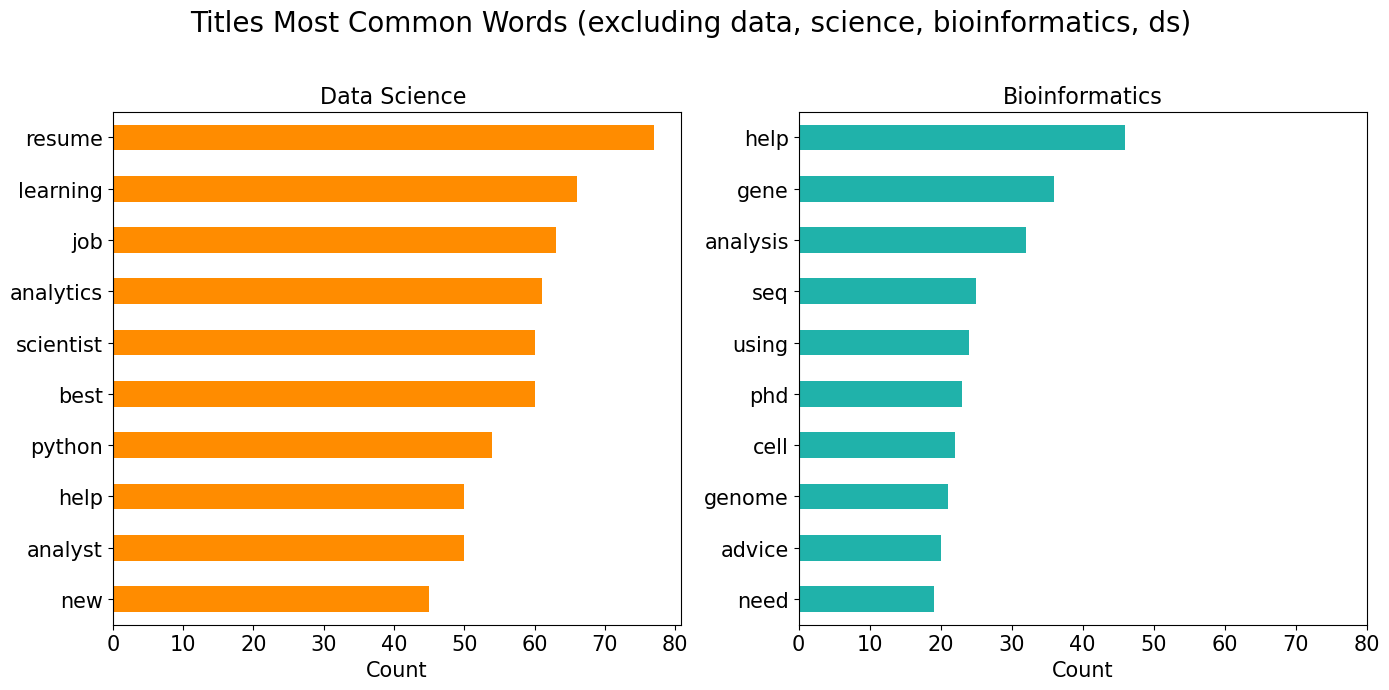

In [319]:
# adapted from breakfast hour and https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller

# Set figure
fig, ax = plt.subplots(1,2, figsize=(14,7))
fig.suptitle('Titles Most Common Words (excluding data, science, bioinformatics, ds) \n', fontsize=20)

# Plot Data Science most common words
datascience_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'datascience'], 'title', 10)
datascience_title_most_common.plot(kind = 'barh', color = 'darkorange', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Data Science', fontsize=16)
ax[0].set_xlabel('Count', fontsize=15)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)

# Plot Bioinformatics most common words
bioinformatics_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'bioinformatics'], 'title', 10)
bioinformatics_title_most_common.plot(kind = 'barh', color = 'lightseagreen', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Bioinformatics', fontsize=16)
ax[1].set_xlabel('Count', fontsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[1].set_xlim([0, 80])

# Save for the presentation
plt.tight_layout()
plt.savefig('../images/title_most_common_words.jpeg');

The only overlap that can be seen here is help. Also, there are several similar words - analytics, analyst, and analysis. This difference should be great for the model performance.

---

### Post Body Most Common Words 

In [320]:
# To find the most common words in Post Body Text I will impute all rows with missing data with 'missing'
reddit_no_missing = reddit.fillna('missing').copy()
datascience_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'datascience'], 'post_body_text', 10)
datascience_post_body_text_most_common

data       1733
science     606
like        495
work        373
https       362
amp         355
missing     350
job         324
know        312
just        301
dtype: int64

'missing' shows even here on Data Science's 10 most common words

In [321]:
bioinformatics_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'bioinformatics'], 'post_body_text', 10)
bioinformatics_post_body_text_most_common

bioinformatics    328
data              313
like              260
amp               254
know              174
using             169
work              165
https             160
ve                154
use               152
dtype: int64

As in the Title the most common words are the names of the Subreddits, I need to remove them for the model to learn the underlying differences between texts.

In [322]:
# Drop data, science, ds, and bioinformatics (also “ve” from I've) from the Reddit data
words_to_delete = ['bioinformatics', 'data', 'science', 'missing', "'ve"]

reddit = remove_words(reddit_no_missing, 'post_body_text', words_to_delete)

In [323]:
datascience_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'datascience'], 'post_body_text', 10)
datascience_post_body_text_most_common

like        495
work        373
https       362
amp         355
job         324
know        312
just        301
time        289
learning    261
want        258
dtype: int64

In [324]:
bioinformatics_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'bioinformatics'], 'post_body_text', 10)
bioinformatics_post_body_text_most_common

like        260
amp         254
know        174
using       169
work        165
https       160
use         152
want        150
just        146
analysis    144
dtype: int64

There are still words that I will need to remove like https and amp. I will delete them in the next part as more are showing in bigrams.

## Most Common Bigrams

---

### Title Most Common Bigrams 

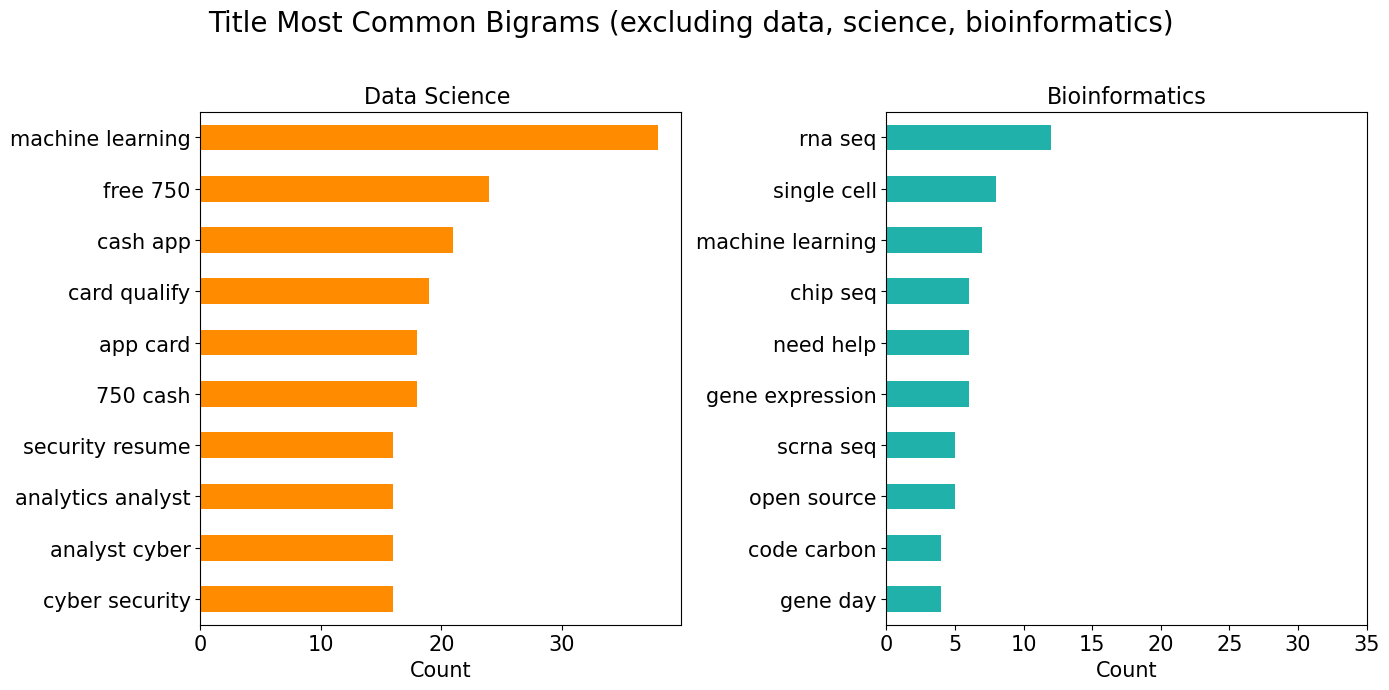

In [330]:
# Most common bigrams in Title

# Set figure
fig, ax = plt.subplots(1,2, figsize=(14,7))
fig.suptitle('Title Most Common Bigrams (excluding data, science, bioinformatics) \n', fontsize=20)

# Plot Data Science most common bigrams
datascience_title_most_common_bigrams = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'datascience'], 'title', 10, (2,2))
datascience_title_most_common_bigrams.plot(kind = 'barh', color = 'darkorange', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Data Science ', fontsize=16)
ax[0].set_xlabel('Count', fontsize=15)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)

# Plot Bioinformatics most common bigrams
bioinformatics_title_most_common_bigrams = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'bioinformatics'], 'title', 10, (2,2))
bioinformatics_title_most_common_bigrams.plot(kind = 'barh', color = 'lightseagreen', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Bioinformatics', fontsize=16)
ax[1].set_xlabel('Count', fontsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[1].set_xlim([0, 35])

# Save for the presentation 
plt.tight_layout()
plt.savefig('../images/title_common_bigrams.jpeg');

For Bioinformatics the bigrams are scarce, even in the top ten the last one has less than 5 repetitions. Bigrams will likely not be helpful for modeling.

---

### Post Body Text Most Common Bigrams 

In [325]:
# Most Common bigrams in Data Science Subreddit
datascience_post_body_most_common_bigrams = count_most_common_words(reddit[reddit['subreddit'] == 'datascience'], 'post_body_text', 10, (2,2))
datascience_post_body_most_common_bigrams

https www           135
amp x200b           135
machine learning    105
don know             64
https preview        41
reddit com           41
auto webp            41
amp auto             41
preview redd         41
amp format           41
dtype: int64

In [326]:
# Most Common bigrams in Bioinformatics Subreddit
bioinformatics_post_body_most_common_bigrams = count_most_common_words(reddit[reddit['subreddit'] == 'bioinformatics'], 'post_body_text', 10, (2,2))
bioinformatics_post_body_most_common_bigrams

fq gz            112
amp x200b         87
_r1 fq            57
_r2 fq            56
https www         45
rna seq           36
wet lab           35
feel like         33
https preview     31
amp auto          31
dtype: int64

For Post Body Text almost all the most common bigrams are parts of the links or other chunks of html. We need to delete them.

In [327]:
# Delete chunks 
reddit['post_body_text'] = delete_links_chunks(reddit, 'post_body_text')

In [328]:
# Most Common bigrams in Data Science Subreddit
datascience_post_body_most_common_bigrams = count_most_common_words(reddit[reddit['subreddit'] == 'datascience'], 'post_body_text', 10, (2,2))
datascience_post_body_most_common_bigrams

machine learning    97
don know            62
entry level         34
feel like           33
thank advance       31
years experience    27
deep learning       24
thanks advance      24
don want            23
let know            21
dtype: int64

In [329]:
# Most Common bigrams in Bioinformatics Subreddit
bioinformatics_post_body_most_common_bigrams = count_most_common_words(reddit[reddit['subreddit'] == 'bioinformatics'], 'post_body_text', 10, (2,2))
bioinformatics_post_body_most_common_bigrams

rna seq                35
wet lab                32
thanks advance         30
feel like              29
don know               28
fastq files            21
single cell            20
machine learning       18
thank advance          17
greatly appreciated    16
dtype: int64

In both subreddits 'thanks advance', 'feel like', 'don know', 'machine learning', 'thank advance' are present (half of all bigrams are the same for both subreddits)

## Most common words for combined text from Title and Post Body

I have cleaned the text columns and now will look at both of them together as it will be the column I will use for models.

In [331]:
# Make a new column with both the Title and Post Body Text
reddit['all_text'] = reddit['post_body_text'] + reddit['title']

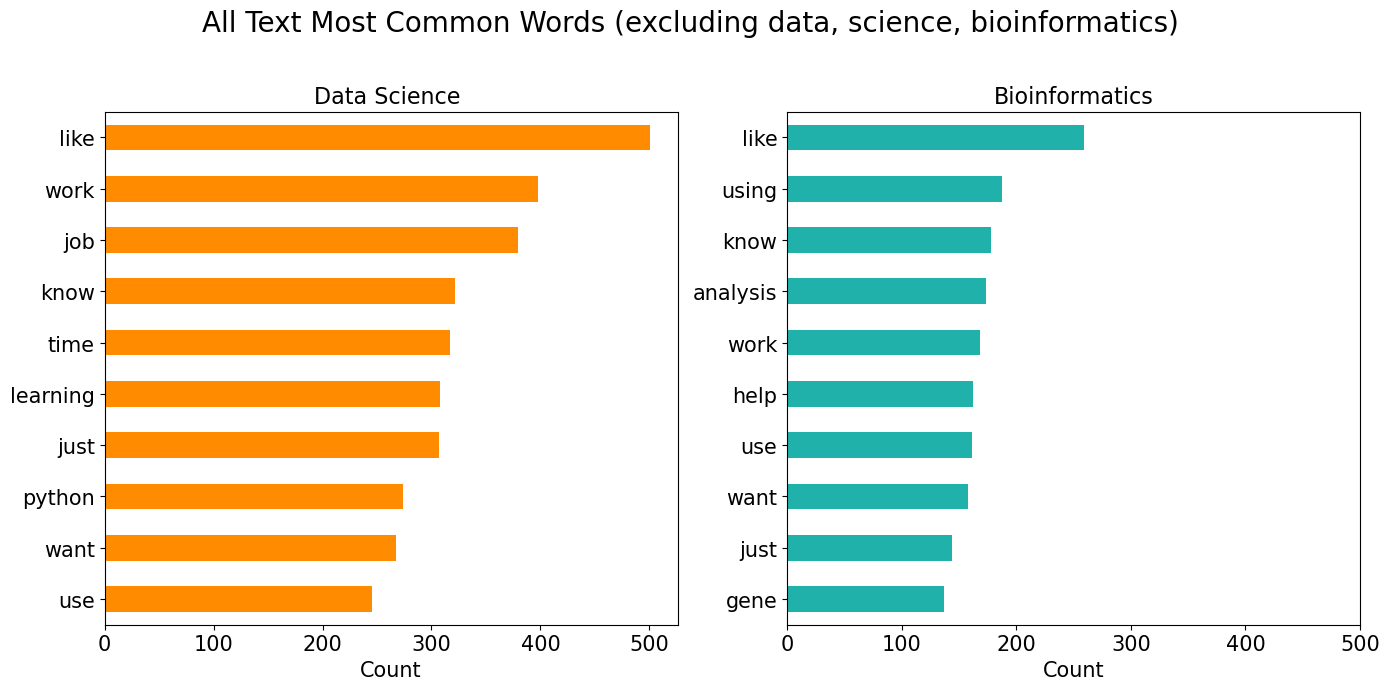

In [332]:
# Set figure
fig, ax = plt.subplots(1,2, figsize=(14,7))
fig.suptitle('All Text Most Common Words (excluding data, science, bioinformatics) \n', fontsize=20)

# Plot Data Science most common words
datascience_all_text_most_common_words = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'datascience'], 'all_text', 10)
datascience_all_text_most_common_words.plot(kind = 'barh', color = 'darkorange', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Data Science ', fontsize=16)
ax[0].set_xlabel('Count', fontsize=15)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)

# Plot Bioinformatics most common words
bioinformatics_all_text_most_common_words = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'bioinformatics'], 'all_text', 10)
bioinformatics_all_text_most_common_words.plot(kind = 'barh', color = 'lightseagreen', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Bioinformatics', fontsize=16)
ax[1].set_xlabel('Count', fontsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[1].set_xlim([0, 500])

# Save for the presentation 
plt.tight_layout()
plt.savefig('../images/all_most_common_words.jpeg');

Like is the most common word for both subreddits. Work, know, just, want, and use are present in both. Six of the top 10 most common words in all text are the same for both subreddits. The texts are close, but my models should manage to differentiate between them.

In [333]:
# Save cleaned data to the file
reddit.to_csv('../data/reddit_cleaned_removed_words.csv', index=False)

---

In this notebook, I have cleaned and explored the data.
The Post Body Text of Data Science subreddit has a substantial amount of missing data and the most common words are similar between subreddits. The bigrams contained almost only parts of the links, which I removed. 
I will model on Title first. It has different top 10 words for Data Science and Bioinformatics. All text has 6 most common words out of 10 the same for both subreddits.
In the next notebook, I will build the first model.